In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
notebook_path = os.path.abspath(os.path.join(os.getcwd(), '../notebooks'))
input_file_path = rf'{notebook_path}\data\processed\session'
model_output_filepath = rf'{notebook_path}\output\model'

In [32]:
# traing:test:backtest = 60:20:20, backtest using the new data
# Step 1: Loading the Data
year = "2023"
ccy = "gbpusd"
session = "london"
file_path = rf'{input_file_path}/{year}_{ccy}_{session}_tick_prev_price_as_base.csv'

# Load the dataset
df = pd.read_csv(file_path)
df["datetime"] = pd.to_datetime(df["datetime"])

# Step 2: Feature Engineering
# Create lagged features
lags = [1, 2, 3]
for lag in lags:
    df[f'lag_{lag}'] = df['price'].shift(lag)

# Include `ticks_moved` as a feature
df['ticks_moved_lag_1'] = df['ticks_moved'].shift(1)  # Add lagged `ticks_moved`

# Fill missing values (introduced by lags)
df.dropna(inplace=True)

# Step 3: Define Features and Target
features = [col for col in df.columns if col.startswith('lag') or 'ticks_moved' in col]
df['target'] = (df['directions'] > 0).astype(int)  # Binary target: 1 for up, 0 for down
""""
The purpose of this line is to create a binary target variable that represents two possible outcomes for each row in the data:

1 (Up): If the value in the directions column is positive, implying the price or movement is upward.
0 (Down): If the value in the directions column is zero or negative, implying the price or movement is flat or downward.
This target column will then be used as the dependent variable (label) for a machine learning model, such as a Random Forest Classifier, to predict future price movements.

1. Expression: df['directions'] > 0
This part checks whether the value in the column directions is greater than 0 for each row in the DataFrame.
The result of this operation is a Boolean Series (True or False) where:
True if the value of directions is greater than 0.
False if the value of directions is less than or equal to 0.
2. Method: .astype(int)
The .astype(int) method converts the Boolean values (True and False) into integers:
True becomes 1
False becomes 0
This conversion is done because most machine learning algorithms work with numerical data, and a binary classification target is typically represented as 0 or 1.
3. Assignment: df['target'] = ...
The result of the Boolean expression (df['directions'] > 0) and its conversion to integers (astype(int)) is assigned to a new column named target in the DataFrame df.

"""
X = df[features]
y = df['target']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split: Split the data into training and testing sets -> 80:20 split
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle=False)

# Step 4: Define Ratios for Splits
train_ratio = 0.6  # 60% for training
test_ratio = 0.2   # 20% for testing
backtest_ratio = 0.2  # 20% for backtesting

# Step 5: Calculate Split Indices
total_rows = len(X_scaled)

# Calculate the end index for training, testing, and backtesting splits
train_end = int(total_rows * train_ratio)  # End of training data
test_end = train_end + int(total_rows * test_ratio)  # End of testing data (start of backtesting)

# Ensure backtesting starts immediately after testing
backtest_start = test_end

# Split the data
X_train, y_train = X_scaled[:train_end], y[:train_end]
X_test, y_test = X_scaled[train_end:test_end], y[train_end:test_end]
X_backtest, y_backtest = X_scaled[backtest_start:], y[backtest_start:]

# Step 5: Train Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

"""""
1. RandomForestClassifier
The RandomForestClassifier is a machine learning model provided by the scikit-learn library. It is used for classification tasks, and it is based on the Random Forest algorithm. The Random Forest algorithm works by:

Creating multiple decision trees during the training phase.
Combining their outputs (e.g., majority voting) to make the final prediction.
This ensemble method reduces overfitting and increases accuracy compared to a single decision tree.

2. random_state=42
Purpose: The random_state parameter is used to control the randomness in the model's training process.
Why Set It?:
The Random Forest model has random components (e.g., choosing subsets of data and features for building decision trees).
By setting random_state=42, you make the results reproducible—i.e., running the code multiple times will produce the same model and predictions. (The choice of 42 is arbitrary; any integer can be used.)
If random_state is not specified, the results may vary between runs due to randomness.

3. Initialization Only
At this step, the RandomForestClassifier model is only being initialized. The model parameters (e.g., number of trees, max depth, etc.) are being set to their default values, except for the random_state.
The model has not yet been trained or fitted to the data. Training happens later when the fit method is called (e.g., rf_model.fit(X_train, y_train)).

"""""

# Step 6: Evaluate Model
y_pred_test = rf_model.predict(X_test)
y_pred_backtest = rf_model.predict(X_backtest)

accuracy = accuracy_score(y_test, y_pred_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)
classification_report_text = classification_report(y_test, y_pred_test)

# Display Results
results = {
    "Accuracy": accuracy,
    "Confusion Matrix": conf_matrix,
    "Classification Report": classification_report_text
}

# Show data used for training and testing
# Add a column to retain the original tick numbers and timestamps
df['tick_number'] = df.index  # Preserve the original row index as tick_number

# Retrieve indices for training, testing, and backtesting data
train_indices = df.iloc[:train_end].index
test_indices = df.iloc[train_end:test_end].index
backtest_indices = df.iloc[test_end:].index

# Extract training, testing, and backtesting data for display
training_data = df.loc[train_indices, ['tick_number', 'datetime']]
testing_data = df.loc[test_indices, ['tick_number', 'datetime']]
backtesting_data = df.loc[backtest_indices, ['tick_number', 'datetime']]

# Print training, testing, and backtesting data samples
print("Training Data (Tick Numbers and Timestamps):")
print(training_data.head())  # Display first 5 rows used for training

print("\nTesting Data (Tick Numbers and Timestamps):")
print(testing_data.head())  # Display first 5 rows used for testing

print("\nBacktesting Data (Tick Numbers and Timestamps):")
print(backtesting_data.head())  # Display first 5 rows used for backtesting


# Results Summary
print("\nModel Evaluation Results:")
print(results)

# Convert the results dictionary into a pandas DataFrame for saving to CSV
results_df = pd.DataFrame.from_dict(
    {key: [value] if not isinstance(value, list) else value for key, value in results.items()}
)

# Save the results DataFrame to CSV
results_df.to_csv(rf'{model_output_filepath}/{year}_{ccy}_{session}_random_forest_results.csv', index=False)


Training Data (Tick Numbers and Timestamps):
   tick_number            datetime
3            3 2023-01-01 18:58:00
4            4 2023-01-01 19:39:00
5            5 2023-01-01 20:03:00
6            6 2023-01-01 20:04:00
7            7 2023-01-01 20:10:00

Testing Data (Tick Numbers and Timestamps):
      tick_number            datetime
4360         4360 2023-07-31 10:48:00
4361         4361 2023-07-31 10:54:00
4362         4362 2023-07-31 14:00:00
4363         4363 2023-07-31 14:16:00
4364         4364 2023-07-31 16:04:00

Backtesting Data (Tick Numbers and Timestamps):
      tick_number            datetime
5812         5812 2023-10-12 13:03:00
5813         5813 2023-10-12 13:36:00
5814         5814 2023-10-12 21:20:00
5815         5815 2023-10-12 22:27:00
5816         5816 2023-10-13 02:22:00

Model Evaluation Results:
{'Accuracy': 0.5075757575757576, 'Confusion Matrix': array([[360, 390],
       [325, 377]]), 'Classification Report': '              precision    recall  f1-score   sup

In [25]:
def run_backtest(df, X_test, y_test, y_pred, initial_balance=10000, lot_size=1000):
    """
    Run a simple backtest using model predictions.

    Parameters:
    - df: DataFrame, the original data with features and target.
    - X_test: array, the test feature set. Provides the inputs for the model to generate predictions; indirectly referenced for metadata.
    - y_test: array, the actual target values for the test set. Used to evaluate whether the model's predictions (y_pred) are correct or not.
    - y_pred: array, the predicted target values for the test set. Drives the simulated trades and determines the backtesting outcomes.
    - initial_balance: float, the starting capital for backtesting.
    - lot_size: float, the trade size in units.

    Returns:
    - balance_history: list of balances over time.
    - trade_log: list of trades with details.
    """
    # Initialize variables
    balance = initial_balance
    balance_history = [balance]
    trade_log = []

    for i in range(len(y_pred)):
        actual = y_test.iloc[i]
        predicted = y_pred[i]
        price = df.iloc[len(df) - len(X_test) + i]['price']  # Match test index to df
        
        """
        # Simulate a trade based on predicted direction
        if predicted == 1:  # Buy signal
            trade_profit = (price * 0.0001 * lot_size) if actual == 1 else -(price * 0.0001 * lot_size)
        else:  # Sell signal
            trade_profit = -(price * 0.0001 * lot_size) if actual == 1 else (price * 0.0001 * lot_size)
        """
        # Simulate a trade based on predicted direction: previous balance + direction * lot_size * fx_return
        fx_return = df.iloc[len(df) - len(X_test) + i]['fx_return']  # Match test index to df

        # Simulate a trade based on predicted direction
        if predicted == 1:  # Buy signal
            trade_profit = fx_return * lot_size if actual == 1 else -fx_return * lot_size
        else:  # Sell signal
            trade_profit = -fx_return * lot_size if actual == 1 else fx_return * lot_size

        # Update balance
        balance += trade_profit
        balance_history.append(balance)

        # Log trade
        trade_log.append({
            'tick': df.iloc[len(df) - len(X_test) + i]['tick_number'],
            'datetime': df.iloc[len(df) - len(X_test) + i]['datetime'],
            'price': price,
            'predicted': predicted,
            'actual': actual,
            'fx_return':fx_return,
            'profit': trade_profit,
            'balance': balance
        })

    return balance_history, trade_log


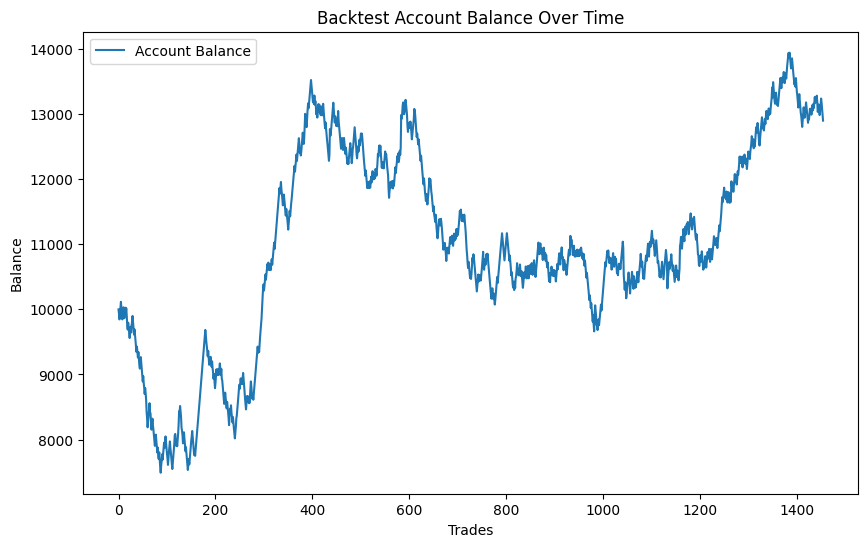

Test set size: 1452
      tick            datetime    price  predicted  actual  fx_return  \
0     5812 2023-10-12 13:03:00  1.21915          0       0  -0.068035   
1     5813 2023-10-12 13:36:00  1.21815          0       0  -0.086127   
2     5814 2023-10-12 21:20:00  1.21915          1       1   0.094411   
3     5815 2023-10-12 22:27:00  1.22015          1       1   0.081199   
4     5816 2023-10-13 02:22:00  1.21915          1       0  -0.094245   
...    ...                 ...      ...        ...     ...        ...   
1448  7260 2023-12-29 13:02:00  1.27515          1       0  -0.100296   
1449  7261 2023-12-29 14:06:00  1.27415          0       0  -0.065101   
1450  7262 2023-12-29 15:09:00  1.27515          0       1   0.097323   
1451  7263 2023-12-29 16:09:00  1.27415          0       0  -0.100365   
1452  7264 2023-12-29 16:56:00  1.27315          0       0  -0.076919   

          profit       balance  
0     -68.035018   9931.964982  
1     -86.126992   9845.837990  
2   

In [26]:
# Run backtest -> train:test:backtest=60:40:40, backtest using the new data
balance_history, trade_log = run_backtest(df.iloc[test_end:], X_backtest, y_backtest, y_pred_backtest)

# Convert trade_log to a DataFrame for easier analysis
trade_log_df = pd.DataFrame(trade_log)

# Plot balance history
plt.figure(figsize=(10, 6))
plt.plot(balance_history, label='Account Balance')
plt.title('Backtest Account Balance Over Time')
plt.xlabel('Trades')
plt.ylabel('Balance')
plt.legend()
plt.show()

print(f"Test set size: {len(X_test)}")

# Display trade log
print(trade_log_df)
trade_log_df.to_csv(rf'{model_output_filepath}/{year}_{ccy}_{session}_backtesting.csv')

